In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys
sys.path.append('../..')

In [6]:
import deepmatcher as dm
from utilities_functions.intermediate_layer_extraction import return_layer_input
from utilities_functions.ri_calculator import find_smallest_variation_to_change_v1
import torch
import pandas as pd
from tqdm import tqdm

## Dataset creation with hybrid model

In [7]:
attributes = ['title','authors','venue','year']

In [5]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/dblp_acm_hybrid.pth')

In [5]:
testneg_hybrid,testneg_ids_hybrid = return_layer_input('../../Structured/DBLP-ACM/',
                                                                         'negatives_frac',
                                                           batch_size=128,model=hybrid_model,
                                                                         layer=hybrid_model.classifier,device=-1)

In [6]:
testpos_hybrid,testpos_ids = return_layer_input('../../Structured/DBLP-ACM/','positives_frac',
                                                           batch_size=128,model=hybrid_model,
                                                layer=hybrid_model.classifier,
                                                          device=-1)

In [7]:
positives_hybrid,pos_ids_hybrid = return_layer_input('../../Structured/DBLP-ACM/','positives',
                                                           batch_size=128,model=hybrid_model,
                                              layer=hybrid_model.classifier,
                                                          device=-1)

In [8]:
negatives_hybrid,neg_ids_hybrid = return_layer_input('../../Structured/DBLP-ACM/','negatives',
                                                           batch_size=128,model=hybrid_model,
                                              layer=hybrid_model.classifier,
                                                          device=-1)

In [9]:
hybrid_model = hybrid_model.cuda()

## Dataset creation with rnn model

In [8]:
rnn_model = dm.MatchingModel(attr_summarizer='rnn')
rnn_model.load_state('../../models/dblp_acm_rnn.pth')

In [9]:
testneg_classifier_inputs_rnn,testneg_ids_rnn = return_layer_input('../../Structured/DBLP-ACM/','negatives_frac',
                                                           batch_size=128,model=rnn_model,layer=rnn_model.classifier,
                                                          device=-1)

In [10]:
testpos_classifier_inputs_rnn,testpos_ids_rnn = return_layer_input('../../Structured/DBLP-ACM/','positives_frac',
                                                           batch_size=128,model=rnn_model,layer=rnn_model.classifier,
                                                          device=-1)

In [11]:
pos_classifier_inputs_rnn,pos_ids_rnn = return_layer_input('../../Structured/DBLP-ACM/','positives',
                                                           batch_size=128,model=rnn_model,layer=rnn_model.classifier,
                                                          device=-1)

In [12]:
neg_classifier_inputs_rnn,neg_ids_rnn = return_layer_input('../../Structured/DBLP-ACM/','negatives',
                                                           batch_size=128,model=rnn_model,layer=rnn_model.classifier,
                                                          device=-1)

In [13]:
rnn_model = rnn_model.cuda()

In [14]:
## Basta scegliere un campione a caso
classifier_length = len(testneg_classifier_inputs_rnn[0][0])
attribute_length = int(classifier_length/len(attributes))

## Ri discovery with rnn model

In [15]:
current_sample = 0
#each column of this matrix is related to a specific attribute
negatives_ri_rnn = []
for batch in testneg_classifier_inputs_rnn:
    for sample_index in tqdm(range(len(batch))):
        current_sample_ris = []
        for j,attribute in enumerate(attributes):
            variation = find_smallest_variation_to_change_v1(rnn_model.classifier,
                                                             classifier_length= classifier_length,
                                                             attribute_length= attribute_length,
                                                          input_matrix=batch,
                                                             vector_index=sample_index,attributes=[j],
                                                          class_to_reach=1)
            current_sample_ris.append(variation)
        negatives_ri_rnn.append(current_sample_ris)
        current_sample+=1

100%|██████████| 128/128 [00:22<00:00,  5.81it/s]


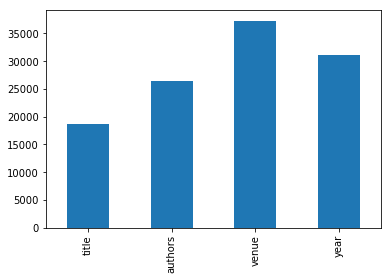

In [17]:
ri_norms_negative_samples = []
for ri_list in negatives_ri_rnn:
    ri_norms_negative_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
negatives_variation_df = pd.DataFrame(data= ri_norms_negative_samples,columns=attributes)
ri_sums = negatives_variation_df.sum(numeric_only=True)
ri_sums.plot.bar()

In [19]:
current_sample = 0
#each column of this matrix is related to a specific attribute
positives_ri_rnn = []
for batch in testpos_classifier_inputs_rnn:
    for sample_index in tqdm(range(len(batch))):
        current_sample_ris = []
        for j,attribute in enumerate(attributes):
            variation = find_smallest_variation_to_change_v1(rnn_model.classifier,
                                                             classifier_length= classifier_length,
                                                             attribute_length= attribute_length,
                                                          input_matrix=batch,
                                                             vector_index=sample_index,attributes=[j],
                                                          class_to_reach=0)
            current_sample_ris.append(variation)
        positives_ri_rnn.append(current_sample_ris)
        current_sample+=1

100%|██████████| 128/128 [00:04<00:00, 31.04it/s]


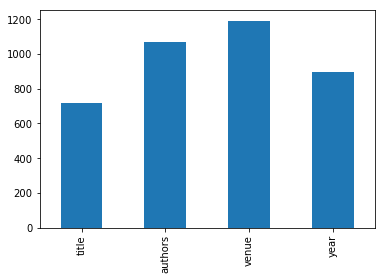

In [20]:
ri_norms_positives = []
for ri_list in positives_ri_rnn:
    ri_norms_positives.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
positives_variation_df = pd.DataFrame(data= ri_norms_positives,columns=attributes)
positives_variation_df.sum(numeric_only=True).plot.bar()

In [21]:
negatives_variation_df.to_csv('experiment_results/testneg_ri_rnn.csv',index=False)

In [22]:
positives_variation_df.to_csv('experiment_results/testpos_r1_rnn.csv',index=False)

## Ri discovery with hybrid model

In [16]:
classifier_length = len(testneg_hybrid[0][0])
attribute_length = int(classifier_length/len(attributes))

In [18]:
current_sample = 0
#each column of this matrix is related to a specific attribute
negatives_ri_hybrid = []
for batch in testneg_hybrid:
    for sample_index in tqdm(range(len(batch))):
        current_sample_ris = []
        for j,attribute in enumerate(attributes):
            variation = find_smallest_variation_to_change_v1(hybrid_model.classifier,
                                                             classifier_length= classifier_length,
                                                             attribute_length= attribute_length,
                                                          input_matrix=batch,
                                                             vector_index=sample_index,attributes=[j],
                                                          class_to_reach=1)
            current_sample_ris.append(variation)
        negatives_ri_hybrid.append(current_sample_ris)
        current_sample+=1

100%|██████████| 128/128 [00:27<00:00,  4.59it/s]


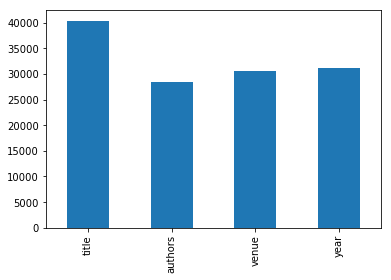

In [21]:
ri_norms_negatives = []
for ri_list in negatives_ri_hybrid:
    ri_norms_negatives.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
negatives_variation_df = pd.DataFrame(data= ri_norms_negatives,columns=attributes)
ri_sums = negatives_variation_df.sum(numeric_only=True)
ri_sums.plot.bar()

In [25]:
negatives_variation_df.to_csv('experiment_results/testneg_ri_hybrid.csv',index=False)

In [22]:
current_sample = 0
#each column of this matrix is related to a specific attribute
positives_ri_hybrid = []
for batch in testpos_hybrid:
    for sample_index in tqdm(range(len(batch))):
        current_sample_ris = []
        for j,attribute in enumerate(attributes):
            variation = find_smallest_variation_to_change_v1(hybrid_model.classifier,
                                                             classifier_length= classifier_length,
                                                             attribute_length= attribute_length,
                                                          input_matrix=batch,
                                                             vector_index=sample_index,attributes=[j],
                                                          class_to_reach=0)
            current_sample_ris.append(variation)
        positives_ri_hybrid.append(current_sample_ris)
        current_sample+=1

100%|██████████| 128/128 [00:15<00:00,  8.18it/s]


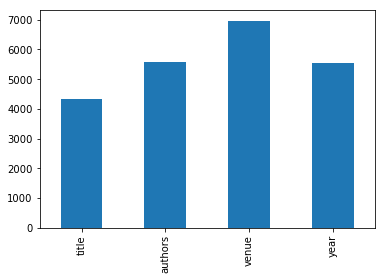

In [23]:
ri_norms_positives = []
for ri_list in positives_ri_hybrid:
    ri_norms_positives.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
positives_variation_df = pd.DataFrame(data= ri_norms_positives,columns=attributes)
positives_variation_df.sum(numeric_only=True).plot.bar()

In [26]:
positives_variation_df.to_csv('experiment_results/testpos_ri_hybrid.csv',index=False)

## Nearest neighbors discovery on Rnn model

In [26]:
from utilities_functions.distance_measures import calculate_nearest_neighbors_onAttributes

In [28]:
negatives_closer_vectors_df = calculate_nearest_neighbors_onAttributes(testneg_classifier_inputs_rnn,
                                                                       testneg_ids_rnn,negatives_ri_rnn,
                                                                      pos_classifier_inputs_rnn,pos_ids_rnn,
                                                                      attributes,attribute_length)

100%|██████████| 128/128 [00:00<00:00, 386.73it/s]


In [33]:
negatives_closer_vectors_df.to_csv('experiment_results/testneg_closer_rnn.csv',index=False)

In [34]:
positives_closer_vectors_df = calculate_nearest_neighbors_onAttributes(testpos_classifier_inputs_rnn,
                                                                       testpos_ids_rnn,positives_ri_rnn,
                                                                      neg_classifier_inputs_rnn,neg_ids_rnn,
                                                                      attributes,attribute_length)

100%|██████████| 128/128 [00:00<00:00, 152.01it/s]


In [35]:
positives_closer_vectors_df.to_csv('experiment_results/testpos_closer_rnn.csv',index=False)

## Nearest neighbors discovery on hybrid model

In [30]:
from utilities_functions.distance_measures import nearest_neighbor_onAttribute

In [34]:
#lista di tuple: vettore più vicino considerando tutti gli elementi e closer solo secondo un attributo
negatives_closer_vectors_hybrid = []
i = 0
for batch in testneg_hybrid:
    for sample in tqdm(batch):
        current_sample_closer_vectors = list(map(lambda att: nearest_neighbor_onAttribute
                                                 (sample+negatives_ri_hybrid[i][attributes.index(att)]
                                                                ,positives_hybrid,attributes.index(att),
                                                                attribute_length),attributes))
        negatives_closer_vectors_hybrid.append(current_sample_closer_vectors)
        i += 1 

100%|██████████| 128/128 [00:00<00:00, 437.51it/s]


In [39]:
negatives_closer_vectors_hybrid_df = pd.DataFrame(data = negatives_closer_vectors_hybrid, columns = attributes)
negatives_closer_vectors_hybrid_df = negatives_closer_vectors_hybrid_df.applymap(lambda c:pos_ids_hybrid[c])
negatives_closer_vectors_hybrid_df['SampleID'] = testneg_ids_hybrid
negatives_closer_vectors_hybrid_df.to_csv('experiment_results/negatives_nn_hybrid.csv',index=False)

In [37]:
# per ogni attributo trovo il più vicino
positives_closer_vectors_hybrid = []
i = 0
for batch in testpos_hybrid:
    for sample in tqdm(batch):
        current_sample_closer_vectors = list(map(lambda att: nearest_neighbor_onAttribute
                                                 (sample+positives_ri_hybrid[i][attributes.index(att)]
                                                                ,negatives_hybrid,attributes.index(att),
                                                                attribute_length),attributes))
        positives_closer_vectors_hybrid.append(current_sample_closer_vectors)
        i += 1 

100%|██████████| 128/128 [00:00<00:00, 143.71it/s]


In [41]:
positives_closer_vectors_hybrid_df = pd.DataFrame(data = positives_closer_vectors_hybrid, columns = attributes)
positives_closer_vectors_hybrid_df = positives_closer_vectors_hybrid_df.applymap(lambda c:neg_ids_hybrid[c])
positives_closer_vectors_hybrid_df['SampleID'] = testpos_ids
positives_closer_vectors_hybrid_df.to_csv('experiment_results/positives_nn_hybrid.csv',index=False)